<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:13:33] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


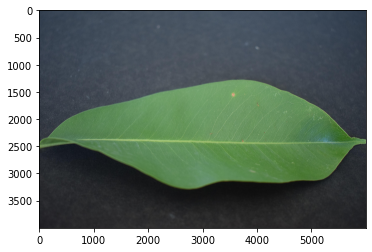

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

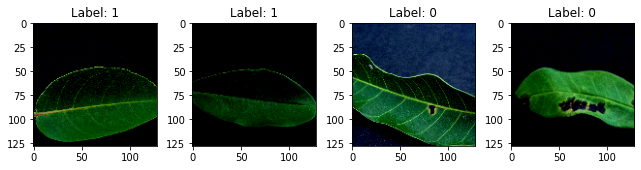

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:13:41] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:13:43] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2415359889838689 samples/sec                   batch loss = 0.7723342776298523 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2575732828521518 samples/sec                   batch loss = 0.40538445115089417 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2659447220058306 samples/sec                   batch loss = 0.8305783867835999 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.2659421428803725 samples/sec                   batch loss = 1.0432913303375244 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.2593264923093275 samples/sec                   batch loss = 1.1366405487060547 | accuracy = 0.63


Epoch[1] Batch[30] Speed: 1.2661817598364045 samples/sec                   batch loss = 0.5919898748397827 | accuracy = 0.6333333333333333


Epoch[1] Batch[35] Speed: 1.2670594094961394 samples/sec                   batch loss = 0.9646462798118591 | accuracy = 0.65


Epoch[1] Batch[40] Speed: 1.2648251285107455 samples/sec                   batch loss = 0.7143523097038269 | accuracy = 0.65


Epoch[1] Batch[45] Speed: 1.2625736287984994 samples/sec                   batch loss = 0.38053444027900696 | accuracy = 0.6555555555555556


Epoch[1] Batch[50] Speed: 1.263435911029713 samples/sec                   batch loss = 0.4361547827720642 | accuracy = 0.65


Epoch[1] Batch[55] Speed: 1.2579579983751803 samples/sec                   batch loss = 1.1597398519515991 | accuracy = 0.6454545454545455


Epoch[1] Batch[60] Speed: 1.2669892713965278 samples/sec                   batch loss = 0.6401381492614746 | accuracy = 0.6416666666666667


Epoch[1] Batch[65] Speed: 1.2645865966099084 samples/sec                   batch loss = 0.45305830240249634 | accuracy = 0.6538461538461539


Epoch[1] Batch[70] Speed: 1.264400276375335 samples/sec                   batch loss = 0.9203502535820007 | accuracy = 0.6392857142857142


Epoch[1] Batch[75] Speed: 1.2623365151548782 samples/sec                   batch loss = 0.5061833262443542 | accuracy = 0.64


Epoch[1] Batch[80] Speed: 1.2652684914644685 samples/sec                   batch loss = 0.5955811142921448 | accuracy = 0.646875


Epoch[1] Batch[85] Speed: 1.2610444067270972 samples/sec                   batch loss = 0.5243294835090637 | accuracy = 0.65


Epoch[1] Batch[90] Speed: 1.2675372823948614 samples/sec                   batch loss = 0.6457797288894653 | accuracy = 0.6527777777777778


Epoch[1] Batch[95] Speed: 1.2652049440468678 samples/sec                   batch loss = 0.48695990443229675 | accuracy = 0.6578947368421053


Epoch[1] Batch[100] Speed: 1.2623651996496994 samples/sec                   batch loss = 0.5629687309265137 | accuracy = 0.6675


Epoch[1] Batch[105] Speed: 1.2638818232599625 samples/sec                   batch loss = 0.872439980506897 | accuracy = 0.6642857142857143


Epoch[1] Batch[110] Speed: 1.2664942197365225 samples/sec                   batch loss = 0.5090019106864929 | accuracy = 0.6681818181818182


Epoch[1] Batch[115] Speed: 1.2633358262879504 samples/sec                   batch loss = 1.2699968814849854 | accuracy = 0.6717391304347826


Epoch[1] Batch[120] Speed: 1.2658798649675107 samples/sec                   batch loss = 0.5308106541633606 | accuracy = 0.6666666666666666


Epoch[1] Batch[125] Speed: 1.2606580855556306 samples/sec                   batch loss = 0.5828301310539246 | accuracy = 0.67


Epoch[1] Batch[130] Speed: 1.2615390006186176 samples/sec                   batch loss = 0.4758837819099426 | accuracy = 0.6653846153846154


Epoch[1] Batch[135] Speed: 1.2655442237781058 samples/sec                   batch loss = 0.6177803874015808 | accuracy = 0.662962962962963


Epoch[1] Batch[140] Speed: 1.2670289802809873 samples/sec                   batch loss = 0.529159426689148 | accuracy = 0.6642857142857143


Epoch[1] Batch[145] Speed: 1.2630119914959141 samples/sec                   batch loss = 0.4565739035606384 | accuracy = 0.6637931034482759


Epoch[1] Batch[150] Speed: 1.2672524489676298 samples/sec                   batch loss = 0.3472740054130554 | accuracy = 0.6633333333333333


Epoch[1] Batch[155] Speed: 1.267840926514764 samples/sec                   batch loss = 0.4747791290283203 | accuracy = 0.6693548387096774


Epoch[1] Batch[160] Speed: 1.2667638869194664 samples/sec                   batch loss = 0.8134714961051941 | accuracy = 0.6703125


Epoch[1] Batch[165] Speed: 1.2608967485636506 samples/sec                   batch loss = 0.3481868803501129 | accuracy = 0.6727272727272727


Epoch[1] Batch[170] Speed: 1.26419467307459 samples/sec                   batch loss = 0.5341233015060425 | accuracy = 0.6705882352941176


Epoch[1] Batch[175] Speed: 1.2623918906981493 samples/sec                   batch loss = 0.33213984966278076 | accuracy = 0.6685714285714286


Epoch[1] Batch[180] Speed: 1.2568254587293932 samples/sec                   batch loss = 0.261311799287796 | accuracy = 0.6666666666666666


Epoch[1] Batch[185] Speed: 1.262154750352435 samples/sec                   batch loss = 0.3705069422721863 | accuracy = 0.6635135135135135


Epoch[1] Batch[190] Speed: 1.2665127676310772 samples/sec                   batch loss = 0.6604793667793274 | accuracy = 0.6671052631578948


Epoch[1] Batch[195] Speed: 1.2698004810905323 samples/sec                   batch loss = 0.4036405682563782 | accuracy = 0.6666666666666666


Epoch[1] Batch[200] Speed: 1.262738121706307 samples/sec                   batch loss = 0.9174008369445801 | accuracy = 0.66375


Epoch[1] Batch[205] Speed: 1.2625404693306026 samples/sec                   batch loss = 0.5647502541542053 | accuracy = 0.6658536585365854


Epoch[1] Batch[210] Speed: 1.2616057853396783 samples/sec                   batch loss = 0.705861508846283 | accuracy = 0.6642857142857143


Epoch[1] Batch[215] Speed: 1.2634776811201722 samples/sec                   batch loss = 0.5003368258476257 | accuracy = 0.663953488372093


Epoch[1] Batch[220] Speed: 1.2639084832653122 samples/sec                   batch loss = 0.7294019460678101 | accuracy = 0.6647727272727273


Epoch[1] Batch[225] Speed: 1.2584834962782314 samples/sec                   batch loss = 1.163228988647461 | accuracy = 0.6644444444444444


Epoch[1] Batch[230] Speed: 1.2588132298464174 samples/sec                   batch loss = 0.5808134078979492 | accuracy = 0.6597826086956522


Epoch[1] Batch[235] Speed: 1.2657005158924959 samples/sec                   batch loss = 0.8484522104263306 | accuracy = 0.6585106382978724


Epoch[1] Batch[240] Speed: 1.2602219229971277 samples/sec                   batch loss = 0.3558292090892792 | accuracy = 0.659375


Epoch[1] Batch[245] Speed: 1.2678217648574186 samples/sec                   batch loss = 0.30724653601646423 | accuracy = 0.6642857142857143


Epoch[1] Batch[250] Speed: 1.261333093956039 samples/sec                   batch loss = 0.4854791760444641 | accuracy = 0.663


Epoch[1] Batch[255] Speed: 1.26007398417466 samples/sec                   batch loss = 0.4226013123989105 | accuracy = 0.6637254901960784


Epoch[1] Batch[260] Speed: 1.266618615754745 samples/sec                   batch loss = 0.3851533830165863 | accuracy = 0.6682692307692307


Epoch[1] Batch[265] Speed: 1.2725589399508883 samples/sec                   batch loss = 0.36050087213516235 | accuracy = 0.6707547169811321


Epoch[1] Batch[270] Speed: 1.2647695392957035 samples/sec                   batch loss = 0.736253559589386 | accuracy = 0.674074074074074


Epoch[1] Batch[275] Speed: 1.2728056069183533 samples/sec                   batch loss = 0.343791663646698 | accuracy = 0.6754545454545454


Epoch[1] Batch[280] Speed: 1.2644583109083354 samples/sec                   batch loss = 0.556045413017273 | accuracy = 0.6758928571428572


Epoch[1] Batch[285] Speed: 1.2613955891495663 samples/sec                   batch loss = 0.4976528286933899 | accuracy = 0.6754385964912281


Epoch[1] Batch[290] Speed: 1.2656578348620309 samples/sec                   batch loss = 0.2627362310886383 | accuracy = 0.6758620689655173


Epoch[1] Batch[295] Speed: 1.2586046240164956 samples/sec                   batch loss = 0.3602956533432007 | accuracy = 0.6754237288135593


Epoch[1] Batch[300] Speed: 1.2652124816200785 samples/sec                   batch loss = 0.5938390493392944 | accuracy = 0.6733333333333333


Epoch[1] Batch[305] Speed: 1.2599870165255418 samples/sec                   batch loss = 0.29344984889030457 | accuracy = 0.6729508196721311


Epoch[1] Batch[310] Speed: 1.2661123877053821 samples/sec                   batch loss = 0.6972322463989258 | accuracy = 0.6717741935483871


Epoch[1] Batch[315] Speed: 1.2669268904168036 samples/sec                   batch loss = 0.19910573959350586 | accuracy = 0.6746031746031746


Epoch[1] Batch[320] Speed: 1.2635854017057015 samples/sec                   batch loss = 0.5456292629241943 | accuracy = 0.671875


Epoch[1] Batch[325] Speed: 1.2755543613939515 samples/sec                   batch loss = 0.466480016708374 | accuracy = 0.6723076923076923


Epoch[1] Batch[330] Speed: 1.2660412079524204 samples/sec                   batch loss = 0.18264850974082947 | accuracy = 0.6742424242424242


Epoch[1] Batch[335] Speed: 1.270878649354498 samples/sec                   batch loss = 0.3846067786216736 | accuracy = 0.6723880597014925


Epoch[1] Batch[340] Speed: 1.2671802795842415 samples/sec                   batch loss = 0.6621143221855164 | accuracy = 0.6735294117647059


Epoch[1] Batch[345] Speed: 1.2670008489106024 samples/sec                   batch loss = 0.2811310589313507 | accuracy = 0.6753623188405797


Epoch[1] Batch[350] Speed: 1.273205690610523 samples/sec                   batch loss = 0.6528650522232056 | accuracy = 0.6771428571428572


Epoch[1] Batch[355] Speed: 1.2657351784447102 samples/sec                   batch loss = 0.7606940865516663 | accuracy = 0.6753521126760563


Epoch[1] Batch[360] Speed: 1.2737537747291021 samples/sec                   batch loss = 0.5773182511329651 | accuracy = 0.6763888888888889


Epoch[1] Batch[365] Speed: 1.2716311512195322 samples/sec                   batch loss = 0.6648572683334351 | accuracy = 0.6767123287671233


Epoch[1] Batch[370] Speed: 1.2684834646383694 samples/sec                   batch loss = 0.1251952350139618 | accuracy = 0.6790540540540541


Epoch[1] Batch[375] Speed: 1.2655202630365503 samples/sec                   batch loss = 0.787704348564148 | accuracy = 0.6786666666666666


Epoch[1] Batch[380] Speed: 1.272680668527658 samples/sec                   batch loss = 0.8068622946739197 | accuracy = 0.6789473684210526


Epoch[1] Batch[385] Speed: 1.2692390851912716 samples/sec                   batch loss = 0.9980685710906982 | accuracy = 0.6785714285714286


Epoch[1] Batch[390] Speed: 1.2677415796051668 samples/sec                   batch loss = 0.4463917016983032 | accuracy = 0.6788461538461539


Epoch[1] Batch[395] Speed: 1.2666967462688912 samples/sec                   batch loss = 0.1403743177652359 | accuracy = 0.6810126582278481


Epoch[1] Batch[400] Speed: 1.264745798564328 samples/sec                   batch loss = 0.5988756418228149 | accuracy = 0.68125


Epoch[1] Batch[405] Speed: 1.2689411054628736 samples/sec                   batch loss = 0.6180751919746399 | accuracy = 0.6820987654320988


Epoch[1] Batch[410] Speed: 1.2623454433016157 samples/sec                   batch loss = 0.4530458152294159 | accuracy = 0.6835365853658537


Epoch[1] Batch[415] Speed: 1.2675442731943185 samples/sec                   batch loss = 0.3664795160293579 | accuracy = 0.686144578313253


Epoch[1] Batch[420] Speed: 1.2643269070050058 samples/sec                   batch loss = 0.8161779046058655 | accuracy = 0.6869047619047619


Epoch[1] Batch[425] Speed: 1.274717593322836 samples/sec                   batch loss = 0.45665282011032104 | accuracy = 0.6888235294117647


Epoch[1] Batch[430] Speed: 1.2680446507412226 samples/sec                   batch loss = 0.4530622959136963 | accuracy = 0.688953488372093


Epoch[1] Batch[435] Speed: 1.2661199360948585 samples/sec                   batch loss = 0.4436793923377991 | accuracy = 0.6879310344827586


Epoch[1] Batch[440] Speed: 1.2691621768971582 samples/sec                   batch loss = 0.3719278573989868 | accuracy = 0.6880681818181819


Epoch[1] Batch[445] Speed: 1.2690376647526584 samples/sec                   batch loss = 0.8006303310394287 | accuracy = 0.6882022471910112


Epoch[1] Batch[450] Speed: 1.2659753857470226 samples/sec                   batch loss = 0.7688232660293579 | accuracy = 0.6888888888888889


Epoch[1] Batch[455] Speed: 1.2676156220639496 samples/sec                   batch loss = 0.6146129369735718 | accuracy = 0.6873626373626374


Epoch[1] Batch[460] Speed: 1.259417339499547 samples/sec                   batch loss = 0.5021849274635315 | accuracy = 0.6858695652173913


Epoch[1] Batch[465] Speed: 1.263392050650096 samples/sec                   batch loss = 1.221356749534607 | accuracy = 0.6849462365591398


Epoch[1] Batch[470] Speed: 1.2691954930787863 samples/sec                   batch loss = 0.3663347065448761 | accuracy = 0.6856382978723404


Epoch[1] Batch[475] Speed: 1.2591836779113117 samples/sec                   batch loss = 0.45133304595947266 | accuracy = 0.6842105263157895


Epoch[1] Batch[480] Speed: 1.2684998649254435 samples/sec                   batch loss = 1.2707809209823608 | accuracy = 0.6828125


Epoch[1] Batch[485] Speed: 1.2661194583460211 samples/sec                   batch loss = 0.5054302215576172 | accuracy = 0.6829896907216495


Epoch[1] Batch[490] Speed: 1.2685496438322605 samples/sec                   batch loss = 0.26113104820251465 | accuracy = 0.6841836734693878


Epoch[1] Batch[495] Speed: 1.2694301960846033 samples/sec                   batch loss = 0.4963403642177582 | accuracy = 0.6848484848484848


Epoch[1] Batch[500] Speed: 1.2654199432503006 samples/sec                   batch loss = 0.36400318145751953 | accuracy = 0.684


Epoch[1] Batch[505] Speed: 1.2652436824037163 samples/sec                   batch loss = 0.7614660263061523 | accuracy = 0.6851485148514852


Epoch[1] Batch[510] Speed: 1.2603287104096839 samples/sec                   batch loss = 0.4014197289943695 | accuracy = 0.6857843137254902


Epoch[1] Batch[515] Speed: 1.2629365014662808 samples/sec                   batch loss = 0.36245620250701904 | accuracy = 0.6849514563106797


Epoch[1] Batch[520] Speed: 1.266287648212506 samples/sec                   batch loss = 0.17159105837345123 | accuracy = 0.6865384615384615


Epoch[1] Batch[525] Speed: 1.2630534482977982 samples/sec                   batch loss = 0.7156251668930054 | accuracy = 0.6871428571428572


Epoch[1] Batch[530] Speed: 1.2673478898064374 samples/sec                   batch loss = 0.5919761061668396 | accuracy = 0.6882075471698114


Epoch[1] Batch[535] Speed: 1.2621689933525018 samples/sec                   batch loss = 0.18853998184204102 | accuracy = 0.6869158878504673


Epoch[1] Batch[540] Speed: 1.264952916415186 samples/sec                   batch loss = 0.4525788128376007 | accuracy = 0.6865740740740741


Epoch[1] Batch[545] Speed: 1.2608717316077016 samples/sec                   batch loss = 0.5381231904029846 | accuracy = 0.6871559633027523


Epoch[1] Batch[550] Speed: 1.2672784855639223 samples/sec                   batch loss = 0.5796469449996948 | accuracy = 0.6872727272727273


Epoch[1] Batch[555] Speed: 1.2633819660476397 samples/sec                   batch loss = 0.5688048005104065 | accuracy = 0.6869369369369369


Epoch[1] Batch[560] Speed: 1.2659728064966198 samples/sec                   batch loss = 0.48839953541755676 | accuracy = 0.6870535714285714


Epoch[1] Batch[565] Speed: 1.264666192576851 samples/sec                   batch loss = 0.7914878129959106 | accuracy = 0.6880530973451328


Epoch[1] Batch[570] Speed: 1.2653920741633753 samples/sec                   batch loss = 0.7200414538383484 | accuracy = 0.6885964912280702


Epoch[1] Batch[575] Speed: 1.2680075615418265 samples/sec                   batch loss = 0.40350377559661865 | accuracy = 0.6891304347826087


Epoch[1] Batch[580] Speed: 1.2637513958748017 samples/sec                   batch loss = 0.49295279383659363 | accuracy = 0.6900862068965518


Epoch[1] Batch[585] Speed: 1.266242060522225 samples/sec                   batch loss = 0.3580555021762848 | accuracy = 0.6918803418803419


Epoch[1] Batch[590] Speed: 1.2680623814867846 samples/sec                   batch loss = 0.23064059019088745 | accuracy = 0.6932203389830508


Epoch[1] Batch[595] Speed: 1.2662329816048008 samples/sec                   batch loss = 0.915666401386261 | accuracy = 0.6928571428571428


Epoch[1] Batch[600] Speed: 1.268237511211364 samples/sec                   batch loss = 0.1979038417339325 | accuracy = 0.6945833333333333


Epoch[1] Batch[605] Speed: 1.2631345631690152 samples/sec                   batch loss = 0.27469903230667114 | accuracy = 0.6942148760330579


Epoch[1] Batch[610] Speed: 1.2593217659671792 samples/sec                   batch loss = 0.2823117673397064 | accuracy = 0.6954918032786885


Epoch[1] Batch[615] Speed: 1.2652144852938902 samples/sec                   batch loss = 0.44457003474235535 | accuracy = 0.6955284552845529


Epoch[1] Batch[620] Speed: 1.2660847747436508 samples/sec                   batch loss = 0.7103880643844604 | accuracy = 0.6963709677419355


Epoch[1] Batch[625] Speed: 1.2632228218966846 samples/sec                   batch loss = 0.7003676295280457 | accuracy = 0.6964


Epoch[1] Batch[630] Speed: 1.2679535129500847 samples/sec                   batch loss = 0.9453698396682739 | accuracy = 0.696031746031746


Epoch[1] Batch[635] Speed: 1.2660336605016393 samples/sec                   batch loss = 0.44034188985824585 | accuracy = 0.6952755905511812


Epoch[1] Batch[640] Speed: 1.2660346158701814 samples/sec                   batch loss = 0.6503581404685974 | accuracy = 0.6953125


Epoch[1] Batch[645] Speed: 1.2659215102550243 samples/sec                   batch loss = 2.2718586921691895 | accuracy = 0.6949612403100776


Epoch[1] Batch[650] Speed: 1.2696609503271319 samples/sec                   batch loss = 0.5137094259262085 | accuracy = 0.6946153846153846


Epoch[1] Batch[655] Speed: 1.2720929955717297 samples/sec                   batch loss = 0.42951494455337524 | accuracy = 0.6954198473282442


Epoch[1] Batch[660] Speed: 1.2634376236442715 samples/sec                   batch loss = 0.2988119125366211 | accuracy = 0.6962121212121212


Epoch[1] Batch[665] Speed: 1.2630368081994479 samples/sec                   batch loss = 0.45733076333999634 | accuracy = 0.6958646616541353


Epoch[1] Batch[670] Speed: 1.2648381922086005 samples/sec                   batch loss = 0.6740282773971558 | accuracy = 0.6958955223880597


Epoch[1] Batch[675] Speed: 1.2632251046135998 samples/sec                   batch loss = 0.4625873267650604 | accuracy = 0.6962962962962963


Epoch[1] Batch[680] Speed: 1.264981433807119 samples/sec                   batch loss = 0.8238370418548584 | accuracy = 0.6970588235294117


Epoch[1] Batch[685] Speed: 1.261285396935921 samples/sec                   batch loss = 0.5586367249488831 | accuracy = 0.6974452554744526


Epoch[1] Batch[690] Speed: 1.2628390623151153 samples/sec                   batch loss = 0.1666470766067505 | accuracy = 0.6989130434782609


Epoch[1] Batch[695] Speed: 1.2551468062210551 samples/sec                   batch loss = 0.17992085218429565 | accuracy = 0.6996402877697842


Epoch[1] Batch[700] Speed: 1.2621555099709905 samples/sec                   batch loss = 0.5737853646278381 | accuracy = 0.7003571428571429


Epoch[1] Batch[705] Speed: 1.2599320409952892 samples/sec                   batch loss = 0.7714230418205261 | accuracy = 0.7


Epoch[1] Batch[710] Speed: 1.2728197050619519 samples/sec                   batch loss = 0.7731202840805054 | accuracy = 0.7003521126760563


Epoch[1] Batch[715] Speed: 1.2678729277738887 samples/sec                   batch loss = 0.18458682298660278 | accuracy = 0.7017482517482517


Epoch[1] Batch[720] Speed: 1.2608242589774987 samples/sec                   batch loss = 0.208296000957489 | accuracy = 0.7017361111111111


Epoch[1] Batch[725] Speed: 1.268423525676041 samples/sec                   batch loss = 0.5224251747131348 | accuracy = 0.7017241379310345


Epoch[1] Batch[730] Speed: 1.2577914480129182 samples/sec                   batch loss = 0.20593857765197754 | accuracy = 0.7023972602739726


Epoch[1] Batch[735] Speed: 1.265271354111008 samples/sec                   batch loss = 0.5283897519111633 | accuracy = 0.7037414965986395


Epoch[1] Batch[740] Speed: 1.2653558080117102 samples/sec                   batch loss = 0.551062822341919 | accuracy = 0.7027027027027027


Epoch[1] Batch[745] Speed: 1.274350243176955 samples/sec                   batch loss = 0.8878352642059326 | accuracy = 0.7030201342281879


Epoch[1] Batch[750] Speed: 1.2606829993033533 samples/sec                   batch loss = 1.0998026132583618 | accuracy = 0.7016666666666667


Epoch[1] Batch[755] Speed: 1.267886437772418 samples/sec                   batch loss = 0.26260122656822205 | accuracy = 0.7016556291390729


Epoch[1] Batch[760] Speed: 1.2661055082389376 samples/sec                   batch loss = 0.5537173748016357 | accuracy = 0.7016447368421053


Epoch[1] Batch[765] Speed: 1.2606728631731066 samples/sec                   batch loss = 0.35524511337280273 | accuracy = 0.7029411764705882


Epoch[1] Batch[770] Speed: 1.2698367141345002 samples/sec                   batch loss = 0.5045737028121948 | accuracy = 0.7032467532467532


Epoch[1] Batch[775] Speed: 1.2656685287202043 samples/sec                   batch loss = 0.3595171272754669 | accuracy = 0.7041935483870968


Epoch[1] Batch[780] Speed: 1.262758840778675 samples/sec                   batch loss = 0.4738917946815491 | accuracy = 0.7041666666666667


Epoch[1] Batch[785] Speed: 1.265520740333302 samples/sec                   batch loss = 0.29977190494537354 | accuracy = 0.7044585987261146


[Epoch 1] training: accuracy=0.7049492385786802
[Epoch 1] time cost: 650.6567695140839
[Epoch 1] validation: validation accuracy=0.7044444444444444


Epoch[2] Batch[5] Speed: 1.2665887814307506 samples/sec                   batch loss = 0.5620108246803284 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2617188801387007 samples/sec                   batch loss = 0.9913986325263977 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2651933039203747 samples/sec                   batch loss = 0.19978636503219604 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.2643980846993372 samples/sec                   batch loss = 0.3189554810523987 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2613162146776615 samples/sec                   batch loss = 0.5170779824256897 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2676172502526966 samples/sec                   batch loss = 0.6767242550849915 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.2643248108623975 samples/sec                   batch loss = 0.38690638542175293 | accuracy = 0.7714285714285715


Epoch[2] Batch[40] Speed: 1.2658593298826026 samples/sec                   batch loss = 0.9520083665847778 | accuracy = 0.775


Epoch[2] Batch[45] Speed: 1.2598381868055333 samples/sec                   batch loss = 0.27482032775878906 | accuracy = 0.7777777777777778


Epoch[2] Batch[50] Speed: 1.2650609840972489 samples/sec                   batch loss = 0.07336469739675522 | accuracy = 0.77


Epoch[2] Batch[55] Speed: 1.2607051667356362 samples/sec                   batch loss = 0.8839449882507324 | accuracy = 0.759090909090909


Epoch[2] Batch[60] Speed: 1.273182405068805 samples/sec                   batch loss = 0.15810778737068176 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.2602105636990417 samples/sec                   batch loss = 0.7514018416404724 | accuracy = 0.7692307692307693


Epoch[2] Batch[70] Speed: 1.2601430747590892 samples/sec                   batch loss = 0.8313577771186829 | accuracy = 0.7607142857142857


Epoch[2] Batch[75] Speed: 1.263728930809604 samples/sec                   batch loss = 0.644583523273468 | accuracy = 0.7533333333333333


Epoch[2] Batch[80] Speed: 1.2656255634213047 samples/sec                   batch loss = 0.3609837293624878 | accuracy = 0.75625


Epoch[2] Batch[85] Speed: 1.2701856951692 samples/sec                   batch loss = 0.15411366522312164 | accuracy = 0.7558823529411764


Epoch[2] Batch[90] Speed: 1.2683596609515742 samples/sec                   batch loss = 0.10418594628572464 | accuracy = 0.7527777777777778


Epoch[2] Batch[95] Speed: 1.2625502554680395 samples/sec                   batch loss = 0.5480144023895264 | accuracy = 0.75


Epoch[2] Batch[100] Speed: 1.257897729590184 samples/sec                   batch loss = 0.6136754751205444 | accuracy = 0.7525


Epoch[2] Batch[105] Speed: 1.2612015802967322 samples/sec                   batch loss = 0.5995655655860901 | accuracy = 0.7404761904761905


Epoch[2] Batch[110] Speed: 1.2650848320566273 samples/sec                   batch loss = 0.21466591954231262 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2603137515084206 samples/sec                   batch loss = 0.5019127130508423 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2651038156750054 samples/sec                   batch loss = 0.45877885818481445 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.256926303726783 samples/sec                   batch loss = 0.7167279124259949 | accuracy = 0.734


Epoch[2] Batch[130] Speed: 1.2690980457715115 samples/sec                   batch loss = 1.1238592863082886 | accuracy = 0.7346153846153847


Epoch[2] Batch[135] Speed: 1.269161888868632 samples/sec                   batch loss = 0.9803876876831055 | accuracy = 0.7314814814814815


Epoch[2] Batch[140] Speed: 1.2617554125729897 samples/sec                   batch loss = 0.5938414335250854 | accuracy = 0.7321428571428571


Epoch[2] Batch[145] Speed: 1.2601245236663692 samples/sec                   batch loss = 0.6410862803459167 | accuracy = 0.7310344827586207


Epoch[2] Batch[150] Speed: 1.2620165150002163 samples/sec                   batch loss = 0.48382365703582764 | accuracy = 0.73


Epoch[2] Batch[155] Speed: 1.2691261743445403 samples/sec                   batch loss = 0.43554946780204773 | accuracy = 0.7290322580645161


Epoch[2] Batch[160] Speed: 1.263964472937669 samples/sec                   batch loss = 0.7150647044181824 | accuracy = 0.728125


Epoch[2] Batch[165] Speed: 1.2650837827275043 samples/sec                   batch loss = 0.48736464977264404 | accuracy = 0.7242424242424242


Epoch[2] Batch[170] Speed: 1.2646919323387598 samples/sec                   batch loss = 0.5105907917022705 | accuracy = 0.7220588235294118


Epoch[2] Batch[175] Speed: 1.2684088534811202 samples/sec                   batch loss = 0.2819100320339203 | accuracy = 0.7214285714285714


Epoch[2] Batch[180] Speed: 1.263092815761798 samples/sec                   batch loss = 0.1814948320388794 | accuracy = 0.725


Epoch[2] Batch[185] Speed: 1.2616540758564916 samples/sec                   batch loss = 0.15878967940807343 | accuracy = 0.727027027027027


Epoch[2] Batch[190] Speed: 1.2615940216087211 samples/sec                   batch loss = 0.6037412881851196 | accuracy = 0.7276315789473684


Epoch[2] Batch[195] Speed: 1.2665568449619853 samples/sec                   batch loss = 0.07004325836896896 | accuracy = 0.7269230769230769


Epoch[2] Batch[200] Speed: 1.2608916313782637 samples/sec                   batch loss = 0.3315361440181732 | accuracy = 0.73


Epoch[2] Batch[205] Speed: 1.2628073146590495 samples/sec                   batch loss = 0.5174177885055542 | accuracy = 0.7317073170731707


Epoch[2] Batch[210] Speed: 1.270841682979644 samples/sec                   batch loss = 0.3960246741771698 | accuracy = 0.7333333333333333


Epoch[2] Batch[215] Speed: 1.2635450519144866 samples/sec                   batch loss = 0.358171671628952 | accuracy = 0.7337209302325581


Epoch[2] Batch[220] Speed: 1.2667835905124363 samples/sec                   batch loss = 0.675142765045166 | accuracy = 0.7306818181818182


Epoch[2] Batch[225] Speed: 1.2676584352413727 samples/sec                   batch loss = 0.1507755070924759 | accuracy = 0.7322222222222222


Epoch[2] Batch[230] Speed: 1.2692559851416423 samples/sec                   batch loss = 0.24263978004455566 | accuracy = 0.7358695652173913


Epoch[2] Batch[235] Speed: 1.2651434064609033 samples/sec                   batch loss = 0.48123928904533386 | accuracy = 0.7329787234042553


Epoch[2] Batch[240] Speed: 1.2671638176932976 samples/sec                   batch loss = 0.13165248930454254 | accuracy = 0.73125


Epoch[2] Batch[245] Speed: 1.264615288132895 samples/sec                   batch loss = 0.4721533954143524 | accuracy = 0.7316326530612245


Epoch[2] Batch[250] Speed: 1.2621120232808787 samples/sec                   batch loss = 0.581089437007904 | accuracy = 0.732


Epoch[2] Batch[255] Speed: 1.2611802486546055 samples/sec                   batch loss = 0.3406875431537628 | accuracy = 0.7303921568627451


Epoch[2] Batch[260] Speed: 1.2630794077267513 samples/sec                   batch loss = 0.8634709119796753 | accuracy = 0.7317307692307692


Epoch[2] Batch[265] Speed: 1.2722999219051325 samples/sec                   batch loss = 0.36686694622039795 | accuracy = 0.7320754716981132


Epoch[2] Batch[270] Speed: 1.2702815783603805 samples/sec                   batch loss = 0.6092138886451721 | accuracy = 0.7287037037037037


Epoch[2] Batch[275] Speed: 1.2697191805122827 samples/sec                   batch loss = 0.5401569604873657 | accuracy = 0.7272727272727273


Epoch[2] Batch[280] Speed: 1.2697517571535102 samples/sec                   batch loss = 0.5825854539871216 | accuracy = 0.7258928571428571


Epoch[2] Batch[285] Speed: 1.272217915072718 samples/sec                   batch loss = 0.5749581456184387 | accuracy = 0.7263157894736842


Epoch[2] Batch[290] Speed: 1.2698617997608812 samples/sec                   batch loss = 0.46690064668655396 | accuracy = 0.728448275862069


Epoch[2] Batch[295] Speed: 1.2720765986943052 samples/sec                   batch loss = 0.2734927535057068 | accuracy = 0.7305084745762712


Epoch[2] Batch[300] Speed: 1.2696408688781406 samples/sec                   batch loss = 0.2810562551021576 | accuracy = 0.7316666666666667


Epoch[2] Batch[305] Speed: 1.2690581110997396 samples/sec                   batch loss = 0.5408972501754761 | accuracy = 0.730327868852459


Epoch[2] Batch[310] Speed: 1.2718661774753937 samples/sec                   batch loss = 0.7874413728713989 | accuracy = 0.7290322580645161


Epoch[2] Batch[315] Speed: 1.2766152242832725 samples/sec                   batch loss = 0.23251275718212128 | accuracy = 0.7317460317460317


Epoch[2] Batch[320] Speed: 1.272546681503878 samples/sec                   batch loss = 0.5181630849838257 | accuracy = 0.73203125


Epoch[2] Batch[325] Speed: 1.2715176216643744 samples/sec                   batch loss = 1.1847946643829346 | accuracy = 0.7307692307692307


Epoch[2] Batch[330] Speed: 1.2674888277401586 samples/sec                   batch loss = 0.316244512796402 | accuracy = 0.7303030303030303


Epoch[2] Batch[335] Speed: 1.2692204573583123 samples/sec                   batch loss = 0.32758840918540955 | accuracy = 0.7291044776119403


Epoch[2] Batch[340] Speed: 1.2721681372580242 samples/sec                   batch loss = 0.3863309323787689 | accuracy = 0.7301470588235294


Epoch[2] Batch[345] Speed: 1.2722277553344232 samples/sec                   batch loss = 0.5761024355888367 | accuracy = 0.731159420289855


Epoch[2] Batch[350] Speed: 1.2726398323174293 samples/sec                   batch loss = 0.8470678329467773 | accuracy = 0.7307142857142858


Epoch[2] Batch[355] Speed: 1.2707939379281545 samples/sec                   batch loss = 0.8056043386459351 | accuracy = 0.7316901408450704


Epoch[2] Batch[360] Speed: 1.2643689266025087 samples/sec                   batch loss = 0.5702840089797974 | accuracy = 0.7319444444444444


Epoch[2] Batch[365] Speed: 1.2679106798391042 samples/sec                   batch loss = 0.3418568968772888 | accuracy = 0.7308219178082191


Epoch[2] Batch[370] Speed: 1.2670635242506205 samples/sec                   batch loss = 0.5398149490356445 | accuracy = 0.7331081081081081


Epoch[2] Batch[375] Speed: 1.267856639506001 samples/sec                   batch loss = 1.212701439857483 | accuracy = 0.734


Epoch[2] Batch[380] Speed: 1.2692821041319946 samples/sec                   batch loss = 0.5781010985374451 | accuracy = 0.7322368421052632


Epoch[2] Batch[385] Speed: 1.2659792068780489 samples/sec                   batch loss = 0.5465225577354431 | accuracy = 0.7337662337662337


Epoch[2] Batch[390] Speed: 1.269799039500255 samples/sec                   batch loss = 0.5905793309211731 | accuracy = 0.7339743589743589


Epoch[2] Batch[395] Speed: 1.264444969164807 samples/sec                   batch loss = 0.6933161020278931 | accuracy = 0.7329113924050633


Epoch[2] Batch[400] Speed: 1.2681027327613528 samples/sec                   batch loss = 0.475418359041214 | accuracy = 0.7325


Epoch[2] Batch[405] Speed: 1.2686673447626613 samples/sec                   batch loss = 0.3184492588043213 | accuracy = 0.7345679012345679


Epoch[2] Batch[410] Speed: 1.2718757230350202 samples/sec                   batch loss = 0.44332122802734375 | accuracy = 0.7323170731707317


Epoch[2] Batch[415] Speed: 1.2689670195353508 samples/sec                   batch loss = 0.39552319049835205 | accuracy = 0.733132530120482


Epoch[2] Batch[420] Speed: 1.2724723636925994 samples/sec                   batch loss = 1.1993674039840698 | accuracy = 0.7327380952380952


Epoch[2] Batch[425] Speed: 1.2687315283098857 samples/sec                   batch loss = 0.2838904559612274 | accuracy = 0.7323529411764705


Epoch[2] Batch[430] Speed: 1.267715045023064 samples/sec                   batch loss = 0.6144557595252991 | accuracy = 0.7319767441860465


Epoch[2] Batch[435] Speed: 1.2700741542063805 samples/sec                   batch loss = 0.3715505003929138 | accuracy = 0.7339080459770115


Epoch[2] Batch[440] Speed: 1.2703998895068456 samples/sec                   batch loss = 1.0333555936813354 | accuracy = 0.7346590909090909


Epoch[2] Batch[445] Speed: 1.2714286818553087 samples/sec                   batch loss = 0.2575295567512512 | accuracy = 0.7359550561797753


Epoch[2] Batch[450] Speed: 1.2727192867401835 samples/sec                   batch loss = 0.4337185323238373 | accuracy = 0.7361111111111112


Epoch[2] Batch[455] Speed: 1.2743011694602773 samples/sec                   batch loss = 0.47714003920555115 | accuracy = 0.7373626373626374


Epoch[2] Batch[460] Speed: 1.272909901946153 samples/sec                   batch loss = 0.8240185976028442 | accuracy = 0.7369565217391304


Epoch[2] Batch[465] Speed: 1.2701204990206412 samples/sec                   batch loss = 0.6148632764816284 | accuracy = 0.7365591397849462


Epoch[2] Batch[470] Speed: 1.271955082072533 samples/sec                   batch loss = 0.23025891184806824 | accuracy = 0.7388297872340426


Epoch[2] Batch[475] Speed: 1.2681226697308223 samples/sec                   batch loss = 0.21467407047748566 | accuracy = 0.74


Epoch[2] Batch[480] Speed: 1.2664495731666214 samples/sec                   batch loss = 0.698499321937561 | accuracy = 0.7395833333333334


Epoch[2] Batch[485] Speed: 1.2707861411939827 samples/sec                   batch loss = 0.37887510657310486 | accuracy = 0.7412371134020619


Epoch[2] Batch[490] Speed: 1.2670406542095953 samples/sec                   batch loss = 0.3135727643966675 | accuracy = 0.7413265306122448


Epoch[2] Batch[495] Speed: 1.2768949529392217 samples/sec                   batch loss = 0.7856046557426453 | accuracy = 0.73989898989899


Epoch[2] Batch[500] Speed: 1.273509833537245 samples/sec                   batch loss = 0.6303310394287109 | accuracy = 0.739


Epoch[2] Batch[505] Speed: 1.2690026291169159 samples/sec                   batch loss = 0.3542567491531372 | accuracy = 0.7391089108910891


Epoch[2] Batch[510] Speed: 1.2682020404206322 samples/sec                   batch loss = 0.4090733826160431 | accuracy = 0.7387254901960785


Epoch[2] Batch[515] Speed: 1.270197138841503 samples/sec                   batch loss = 0.41235560178756714 | accuracy = 0.7393203883495145


Epoch[2] Batch[520] Speed: 1.268845424520022 samples/sec                   batch loss = 0.3133958578109741 | accuracy = 0.7403846153846154


Epoch[2] Batch[525] Speed: 1.2662529553949893 samples/sec                   batch loss = 0.49222132563591003 | accuracy = 0.7404761904761905


Epoch[2] Batch[530] Speed: 1.2678353695745042 samples/sec                   batch loss = 0.32789915800094604 | accuracy = 0.7396226415094339


Epoch[2] Batch[535] Speed: 1.2684324442349024 samples/sec                   batch loss = 0.2714956998825073 | accuracy = 0.7397196261682243


Epoch[2] Batch[540] Speed: 1.273016242528135 samples/sec                   batch loss = 0.3837946355342865 | accuracy = 0.7398148148148148


Epoch[2] Batch[545] Speed: 1.2727683352484924 samples/sec                   batch loss = 0.5605510473251343 | accuracy = 0.7394495412844037


Epoch[2] Batch[550] Speed: 1.2805675366837002 samples/sec                   batch loss = 0.11810781806707382 | accuracy = 0.74


Epoch[2] Batch[555] Speed: 1.266178224158282 samples/sec                   batch loss = 0.6028733253479004 | accuracy = 0.7400900900900901


Epoch[2] Batch[560] Speed: 1.2717053707996344 samples/sec                   batch loss = 0.17672087252140045 | accuracy = 0.7410714285714286


Epoch[2] Batch[565] Speed: 1.275706442717435 samples/sec                   batch loss = 0.7170089483261108 | accuracy = 0.7402654867256637


Epoch[2] Batch[570] Speed: 1.277638155174265 samples/sec                   batch loss = 0.26869624853134155 | accuracy = 0.7416666666666667


Epoch[2] Batch[575] Speed: 1.2774831811381127 samples/sec                   batch loss = 0.3075982630252838 | accuracy = 0.7408695652173913


Epoch[2] Batch[580] Speed: 1.2694811046711794 samples/sec                   batch loss = 0.3666577935218811 | accuracy = 0.7422413793103448


Epoch[2] Batch[585] Speed: 1.2772423796005008 samples/sec                   batch loss = 0.7610188126564026 | accuracy = 0.7410256410256411


Epoch[2] Batch[590] Speed: 1.26846687296661 samples/sec                   batch loss = 0.26911434531211853 | accuracy = 0.7406779661016949


Epoch[2] Batch[595] Speed: 1.2704984989651442 samples/sec                   batch loss = 0.6565703749656677 | accuracy = 0.7394957983193278


Epoch[2] Batch[600] Speed: 1.2703883459858154 samples/sec                   batch loss = 0.6462379097938538 | accuracy = 0.74


Epoch[2] Batch[605] Speed: 1.2687296094250642 samples/sec                   batch loss = 0.5917130708694458 | accuracy = 0.7388429752066116


Epoch[2] Batch[610] Speed: 1.2700753079781308 samples/sec                   batch loss = 0.2457832396030426 | accuracy = 0.739344262295082


Epoch[2] Batch[615] Speed: 1.274030412461751 samples/sec                   batch loss = 0.1974204033613205 | accuracy = 0.7402439024390244


Epoch[2] Batch[620] Speed: 1.2707298342876623 samples/sec                   batch loss = 0.3786656856536865 | accuracy = 0.7415322580645162


Epoch[2] Batch[625] Speed: 1.2791414941616714 samples/sec                   batch loss = 0.29466164112091064 | accuracy = 0.7408


Epoch[2] Batch[630] Speed: 1.274440657118879 samples/sec                   batch loss = 0.4163973033428192 | accuracy = 0.7408730158730159


Epoch[2] Batch[635] Speed: 1.2689263253177532 samples/sec                   batch loss = 0.5513865947723389 | accuracy = 0.7413385826771653


Epoch[2] Batch[640] Speed: 1.2704501062645097 samples/sec                   batch loss = 0.3530062437057495 | accuracy = 0.742578125


Epoch[2] Batch[645] Speed: 1.2699546540358635 samples/sec                   batch loss = 0.3168548345565796 | accuracy = 0.7430232558139535


Epoch[2] Batch[650] Speed: 1.2698516116091871 samples/sec                   batch loss = 0.5259705781936646 | accuracy = 0.7419230769230769


Epoch[2] Batch[655] Speed: 1.2742690364509774 samples/sec                   batch loss = 0.3501396179199219 | accuracy = 0.7431297709923664


Epoch[2] Batch[660] Speed: 1.266986209610001 samples/sec                   batch loss = 0.6953174471855164 | accuracy = 0.7428030303030303


Epoch[2] Batch[665] Speed: 1.273168588739209 samples/sec                   batch loss = 0.6557667851448059 | accuracy = 0.7436090225563909


Epoch[2] Batch[670] Speed: 1.269356914100439 samples/sec                   batch loss = 0.6240107417106628 | accuracy = 0.7436567164179104


Epoch[2] Batch[675] Speed: 1.26615060832482 samples/sec                   batch loss = 0.39258328080177307 | accuracy = 0.7440740740740741


Epoch[2] Batch[680] Speed: 1.2653622021559225 samples/sec                   batch loss = 0.6052022576332092 | accuracy = 0.743014705882353


Epoch[2] Batch[685] Speed: 1.2676303716911568 samples/sec                   batch loss = 0.8080453872680664 | accuracy = 0.7427007299270073


Epoch[2] Batch[690] Speed: 1.2667815818656778 samples/sec                   batch loss = 0.4625040888786316 | accuracy = 0.7423913043478261


Epoch[2] Batch[695] Speed: 1.2646457921765286 samples/sec                   batch loss = 0.5750536322593689 | accuracy = 0.7424460431654676


Epoch[2] Batch[700] Speed: 1.2660916539847828 samples/sec                   batch loss = 0.481509268283844 | accuracy = 0.7421428571428571


Epoch[2] Batch[705] Speed: 1.2721159519102838 samples/sec                   batch loss = 0.6778340935707092 | accuracy = 0.7421985815602837


Epoch[2] Batch[710] Speed: 1.267007164007461 samples/sec                   batch loss = 0.5260454416275024 | accuracy = 0.7419014084507042


Epoch[2] Batch[715] Speed: 1.2680688030142417 samples/sec                   batch loss = 0.1998981535434723 | accuracy = 0.7419580419580419


Epoch[2] Batch[720] Speed: 1.2702105060811766 samples/sec                   batch loss = 0.1907239407300949 | accuracy = 0.7427083333333333


Epoch[2] Batch[725] Speed: 1.2656874343758906 samples/sec                   batch loss = 0.4974890351295471 | accuracy = 0.7424137931034482


Epoch[2] Batch[730] Speed: 1.2679275444322509 samples/sec                   batch loss = 0.37196916341781616 | accuracy = 0.7417808219178083


Epoch[2] Batch[735] Speed: 1.2660693922665942 samples/sec                   batch loss = 0.6676477789878845 | accuracy = 0.741156462585034


Epoch[2] Batch[740] Speed: 1.267189180668548 samples/sec                   batch loss = 0.5661322474479675 | accuracy = 0.7418918918918919


Epoch[2] Batch[745] Speed: 1.2635068932801157 samples/sec                   batch loss = 0.5502764582633972 | accuracy = 0.7419463087248322


Epoch[2] Batch[750] Speed: 1.268056630920381 samples/sec                   batch loss = 0.2547173798084259 | accuracy = 0.7426666666666667


Epoch[2] Batch[755] Speed: 1.266798033826704 samples/sec                   batch loss = 0.39008811116218567 | accuracy = 0.743046357615894


Epoch[2] Batch[760] Speed: 1.264803578766802 samples/sec                   batch loss = 0.12614406645298004 | accuracy = 0.74375


Epoch[2] Batch[765] Speed: 1.2724014320607662 samples/sec                   batch loss = 0.3940715193748474 | accuracy = 0.7441176470588236


Epoch[2] Batch[770] Speed: 1.2670822802142405 samples/sec                   batch loss = 0.35718926787376404 | accuracy = 0.7438311688311688


Epoch[2] Batch[775] Speed: 1.2680368877059975 samples/sec                   batch loss = 0.6244450211524963 | accuracy = 0.7441935483870967


Epoch[2] Batch[780] Speed: 1.2642492590895427 samples/sec                   batch loss = 0.8910202383995056 | accuracy = 0.7448717948717949


Epoch[2] Batch[785] Speed: 1.2707684304496343 samples/sec                   batch loss = 0.44412747025489807 | accuracy = 0.7452229299363057


[Epoch 2] training: accuracy=0.7458756345177665
[Epoch 2] time cost: 639.146223783493
[Epoch 2] validation: validation accuracy=0.7544444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7622222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)